In [ ]:
!pip install transformers torchvision pandas numpy seaborn matplotlib Pillow sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# Setup and Data Preparation

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel
from transformers import ViTFeatureExtractor, ViTModel
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Paths
image_dir = '/content/gdrive/MyDrive/MMD1/Images'
csv_path = '/content/gdrive/MyDrive/MMD1/images_description.csv'

# Load the dataset
df = pd.read_csv(csv_path)
print(f"Total samples: {len(df)}")
print(df.head())

Using device: cuda
Mounted at /content/gdrive
Total samples: 19392
                     image_name  \
0  aug_0_bamboo-vaiya (107).jpg   
1  aug_0_bamboo-vaiya (108).jpg   
2   aug_0_bamboo-vaiya (11).jpg   
3  aug_0_bamboo-vaiya (110).jpg   
4  aug_0_bamboo-vaiya (112).jpg   

                                            Captions                Label  
0  পরীক্ষার শুরুতে আমার লেখা পরীক্ষার শেষের দিকে ...  gendered aggression  
1                   স্ত্রী যখন বান্ধুবী ডেল কার্নেগি               others  
2  আরে ভাই একটা দল ছিল যারা কিনা এবারের লিগ জেতার...               others  
3                        বিশ্বাসের ভাইরাস অভিজিৎ রায়               others  
4            আমি আমাকে খেয়ে বেঁচে আছি জহিরুল হক বাপি               others  


# Custom Dataset Class

In [ ]:
class MemeDataset(Dataset):
    def __init__(self, df, image_dir, tokenizer, max_length=128, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform
        self.label_map = {
            'gendered aggression': 0,
            'religious aggression': 1,
            'non-aggressive': 2,
            'others': 3,
            'political aggression': 4
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Image processing
        img_path = os.path.join(self.image_dir, row['image_name'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Text processing
        text = str(row['Captions'])
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Label
        label = self.label_map[row['Label']]

        return {
            'image': image,
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Model Architecture

In [ ]:
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model_name, image_model_name, num_classes, hidden_dim=768):
        super(MultimodalClassifier, self).__init__()

        # Text model (BN-DISTILBERT)
        self.text_model = BertModel.from_pretrained(text_model_name)

        # Image model (ViLBERT or ViT)
        self.image_model = ViTModel.from_pretrained(image_model_name)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # Text features
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # CLS token

        # Image features
        image_outputs = self.image_model(pixel_values=image)
        image_features = image_outputs.last_hidden_state[:, 0, :]  # CLS token

        # Combine features
        combined = torch.cat((text_features, image_features), dim=1)

        # Classification
        logits = self.classifier(combined)

        return logits

# Training Setup

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 2e-5
MAX_LENGTH = 128

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['Label'], random_state=42)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize tokenizer and datasets
text_model_name = "distilbert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(text_model_name)

image_model_name = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

train_dataset = MemeDataset(train_df, image_dir, tokenizer, MAX_LENGTH, transform)
val_dataset = MemeDataset(val_df, image_dir, tokenizer, MAX_LENGTH, transform)
test_dataset = MemeDataset(test_df, image_dir, tokenizer, MAX_LENGTH, transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
model = MultimodalClassifier(
    text_model_name=text_model_name,
    image_model_name=image_model_name,
    num_classes=5
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

Train samples: 13961
Validation samples: 1552
Test samples: 3879


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias',

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# Training Loop


Epoch 1/15


Evaluating: 100%|██████████| 49/49 [07:02<00:00,  8.62s/it]


Train Loss: 1.2496 | Train Acc: 0.4747
Val Loss: 0.8921 | Val Acc: 0.6591
Saved best model!

Epoch 2/15


Evaluating: 100%|██████████| 49/49 [00:50<00:00,  1.04s/it]


Train Loss: 0.7000 | Train Acc: 0.7426
Val Loss: 0.7609 | Val Acc: 0.7216
Saved best model!

Epoch 3/15


Evaluating: 100%|██████████| 49/49 [00:49<00:00,  1.02s/it]


Train Loss: 0.3401 | Train Acc: 0.8890
Val Loss: 0.4042 | Val Acc: 0.8473
Saved best model!

Epoch 4/15


Evaluating: 100%|██████████| 49/49 [00:49<00:00,  1.02s/it]


Train Loss: 0.1215 | Train Acc: 0.9655
Val Loss: 0.2982 | Val Acc: 0.8937
Saved best model!

Epoch 5/15


Evaluating: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Train Loss: 0.0466 | Train Acc: 0.9895
Val Loss: 0.2975 | Val Acc: 0.8976
Saved best model!

Epoch 6/15


Evaluating: 100%|██████████| 49/49 [00:50<00:00,  1.02s/it]


Train Loss: 0.0489 | Train Acc: 0.9865
Val Loss: 0.3130 | Val Acc: 0.9014
Saved best model!

Epoch 7/15


Evaluating: 100%|██████████| 49/49 [00:50<00:00,  1.03s/it]


Train Loss: 0.0215 | Train Acc: 0.9946
Val Loss: 0.3683 | Val Acc: 0.9021
Saved best model!

Epoch 8/15


Evaluating: 100%|██████████| 49/49 [00:50<00:00,  1.02s/it]


Train Loss: 0.0227 | Train Acc: 0.9938
Val Loss: 0.3480 | Val Acc: 0.9072
Saved best model!

Epoch 9/15


Evaluating: 100%|██████████| 49/49 [00:49<00:00,  1.02s/it]


Train Loss: 0.0226 | Train Acc: 0.9939
Val Loss: 0.4024 | Val Acc: 0.8911

Epoch 10/15


Evaluating: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Train Loss: 0.0253 | Train Acc: 0.9933
Val Loss: 0.4815 | Val Acc: 0.8705

Epoch 11/15


Evaluating: 100%|██████████| 49/49 [00:50<00:00,  1.02s/it]


Train Loss: 0.0170 | Train Acc: 0.9953
Val Loss: 0.5094 | Val Acc: 0.8847

Epoch 12/15


Evaluating: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Train Loss: 0.0041 | Train Acc: 0.9990
Val Loss: 0.3109 | Val Acc: 0.9207
Saved best model!

Epoch 13/15


Evaluating: 100%|██████████| 49/49 [00:49<00:00,  1.02s/it]


Train Loss: 0.0013 | Train Acc: 1.0000
Val Loss: 0.3079 | Val Acc: 0.9195

Epoch 14/15


Evaluating: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Train Loss: 0.0011 | Train Acc: 1.0000
Val Loss: 0.3092 | Val Acc: 0.9227
Saved best model!

Epoch 15/15


Evaluating: 100%|██████████| 49/49 [00:49<00:00,  1.01s/it]


Train Loss: 0.0009 | Train Acc: 1.0000
Val Loss: 0.3089 | Val Acc: 0.9207


Evaluating: 100%|██████████| 122/122 [18:19<00:00,  9.02s/it]



Test Loss: 0.2752 | Test Accuracy: 0.9345

Classification Report:
                      precision    recall  f1-score   support

 gendered aggression     0.9191    0.9167    0.9179       768
religious aggression     0.9803    0.9830    0.9816       707
      non-aggressive     0.9251    0.9069    0.9159       967
              others     0.8869    0.9139    0.9002       755
political aggression     0.9720    0.9663    0.9691       682

            accuracy                         0.9345      3879
           macro avg     0.9367    0.9374    0.9369      3879
        weighted avg     0.9348    0.9345    0.9346      3879



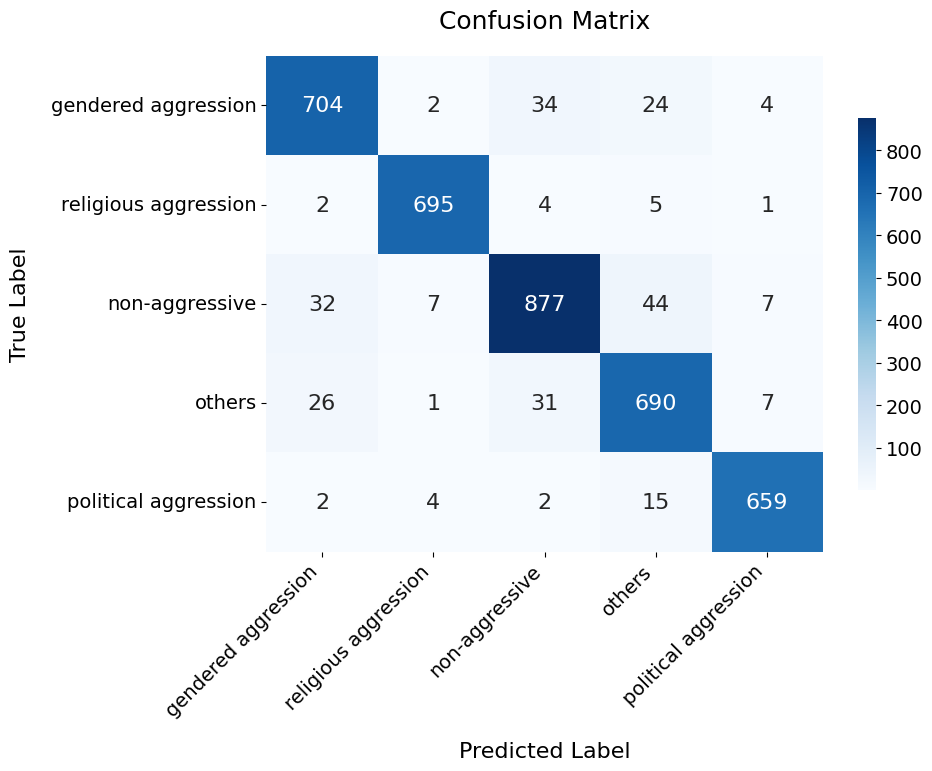

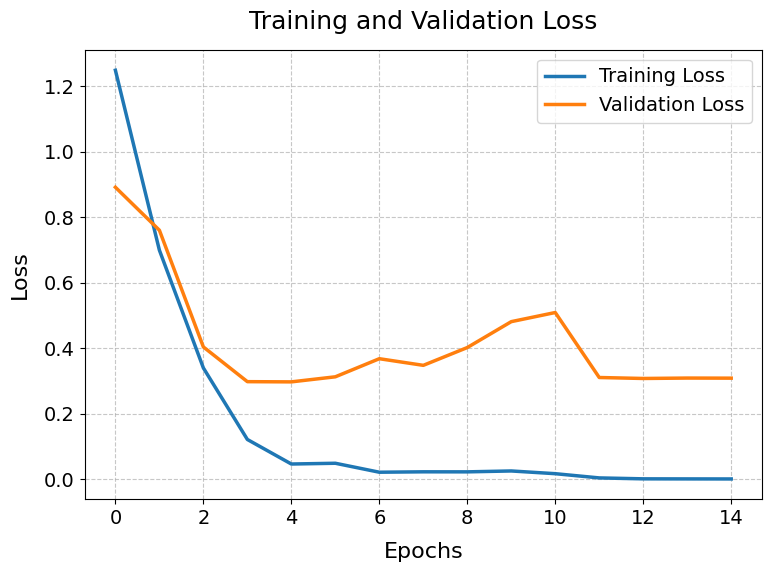

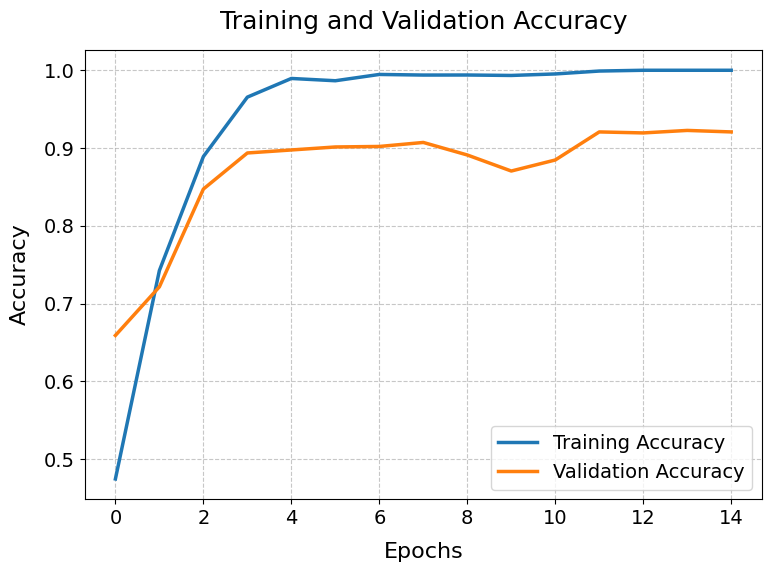

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc="Training"):
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

# Training loop
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update scheduler
    scheduler.step(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_ViLBERT.pth')
        print("Saved best model!")

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load best model
model.load_state_dict(torch.load('best_model_ViLBERT.pth'))

# Test evaluation
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Classification report
label_names = ['gendered aggression', 'religious aggression', 'non-aggressive',
               'others', 'political aggression']
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=label_names, digits=4))

# Set global font sizes for all plots
plt.rcParams.update({
    'font.size': 16,          # Increased general font size
    'axes.titlesize': 18,     # Increased title font size
    'axes.labelsize': 16,     # Increased axis label font size
    'xtick.labelsize': 14,    # Increased X-axis tick label size
    'ytick.labelsize': 14,    # Increased Y-axis tick label size
    'legend.fontsize': 14,    # Increased legend font size
})

# 1. Confusion Matrix Plot
plt.figure(figsize=(10, 8))  # Slightly larger figure size
cm = confusion_matrix(test_labels, test_preds)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            annot_kws={"size": 16},  # Larger and bold annotation font
            cbar_kws={"shrink": 0.75})  # Adjust colorbar size
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted Label', labelpad=15)
plt.xticks(rotation=45, ha='right')
plt.ylabel('True Label', labelpad=15)
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save with high quality
plt.savefig('confusion_matrix.png', dpi=350, bbox_inches='tight')
plt.show()

# 2. Loss Plot (Separate Figure)
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2.5)
plt.plot(val_losses, label='Validation Loss', linewidth=2.5)
plt.title('Training and Validation Loss', pad=15)
plt.xlabel('Epochs', labelpad=10)
plt.ylabel('Loss', labelpad=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Accuracy Plot (Separate Figure)
plt.figure(figsize=(8, 6))
plt.plot(train_accs, label='Training Accuracy', linewidth=2.5)
plt.plot(val_accs, label='Validation Accuracy', linewidth=2.5)
plt.title('Training and Validation Accuracy', pad=15)
plt.xlabel('Epochs', labelpad=10)
plt.ylabel('Accuracy', labelpad=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('accuracy_curve.png', dpi=300, bbox_inches='tight')
plt.show()


# Evaluation and Results Analysis

Evaluating: 100%|██████████| 31/31 [11:28<00:00, 22.21s/it]



Test Loss: 1.2554 | Test Accuracy: 0.6619

Classification Report:
                      precision    recall  f1-score   support

 gendered aggression     0.7097    0.5729    0.6340       192
religious aggression     0.7749    0.8362    0.8043       177
      non-aggressive     0.6133    0.5702    0.5910       242
              others     0.5213    0.5820    0.5500       189
political aggression     0.7234    0.8000    0.7598       170

            accuracy                         0.6619       970
           macro avg     0.6685    0.6723    0.6678       970
        weighted avg     0.6632    0.6619    0.6600       970



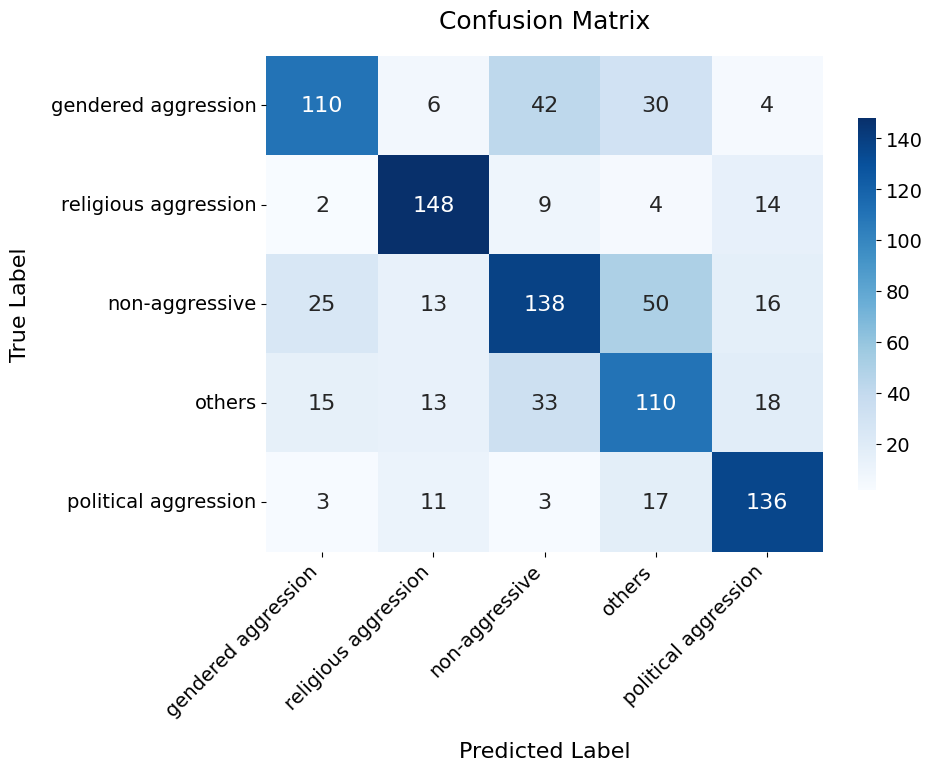

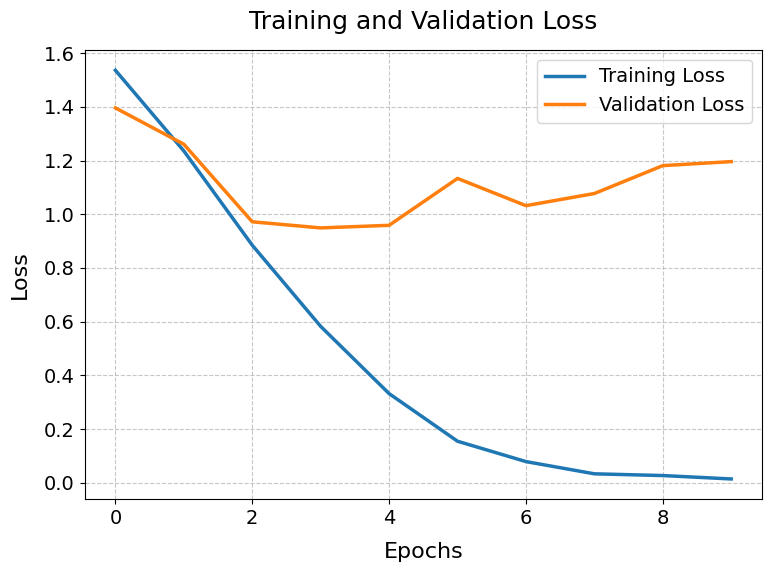

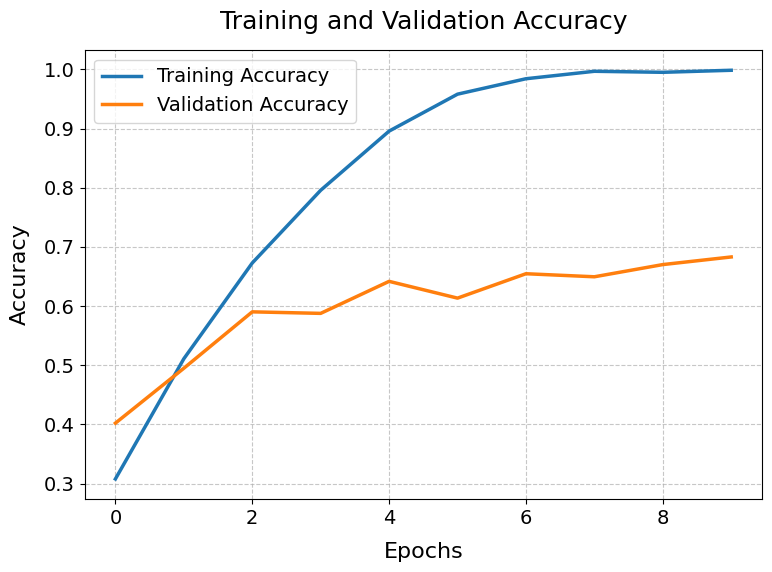

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load best model
model.load_state_dict(torch.load('best_model_ViLBERT.pth'))

# Test evaluation
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Classification report
label_names = ['gendered aggression', 'religious aggression', 'non-aggressive',
               'others', 'political aggression']
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=label_names, digits=4))

# Set global font sizes for all plots
plt.rcParams.update({
    'font.size': 16,          # Increased general font size
    'axes.titlesize': 18,     # Increased title font size
    'axes.labelsize': 16,     # Increased axis label font size
    'xtick.labelsize': 14,    # Increased X-axis tick label size
    'ytick.labelsize': 14,    # Increased Y-axis tick label size
    'legend.fontsize': 14,    # Increased legend font size
})

# 1. Confusion Matrix Plot
plt.figure(figsize=(10, 8))  # Slightly larger figure size
cm = confusion_matrix(test_labels, test_preds)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            annot_kws={"size": 16},  # Larger and bold annotation font
            cbar_kws={"shrink": 0.75})  # Adjust colorbar size
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted Label', labelpad=15)
plt.xticks(rotation=45, ha='right')
plt.ylabel('True Label', labelpad=15)
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save with high quality
plt.savefig('confusion_matrix.png', dpi=350, bbox_inches='tight')
plt.show()

# 2. Loss Plot (Separate Figure)
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2.5)
plt.plot(val_losses, label='Validation Loss', linewidth=2.5)
plt.title('Training and Validation Loss', pad=15)
plt.xlabel('Epochs', labelpad=10)
plt.ylabel('Loss', labelpad=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Accuracy Plot (Separate Figure)
plt.figure(figsize=(8, 6))
plt.plot(train_accs, label='Training Accuracy', linewidth=2.5)
plt.plot(val_accs, label='Validation Accuracy', linewidth=2.5)
plt.title('Training and Validation Accuracy', pad=15)
plt.xlabel('Epochs', labelpad=10)
plt.ylabel('Accuracy', labelpad=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('accuracy_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8ed6db3a1fbbfc7f4464d0efded0e4a47cfb4201c956d870984f6c6ca3f50944
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
!pip install shap


Running LIME and SHAP Explanations


Sample 1/3
True Label: non-aggressive
Text: * কুরআন তেলাওয়াত ডিপ্রেশন...

Predicted Label: non-aggressive (Confidence: 0.99)

LIME Image Explanation:


  0%|          | 0/1000 [00:00<?, ?it/s]

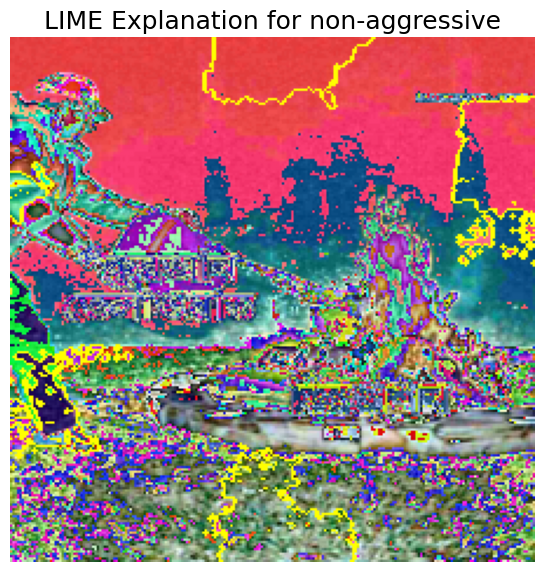


LIME Text Explanation:


Saved LIME text explanation to lime_text_example_1.html

SHAP Image Explanation (this may take a while)...


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 5 is not equal to len(dims) = 3

In [ ]:
import lime
import lime.lime_tabular
import lime.lime_image
import lime.lime_text
from lime import submodular_pick
from skimage.segmentation import mark_boundaries
import shap
from transformers import pipeline

# LIME Analysis Functions -----------------------------------------------------
# Load best model
model.load_state_dict(torch.load('best_model_ViLBERT.pth'))

def lime_image_explanation(model, image, device, top_labels=5, num_samples=1000):
    """
    Explain image classification using LIME
    """
    # Define the prediction function for LIME
    def batch_predict(images):
        model.eval()
        batch = torch.stack([transforms.ToTensor()(img) for img in images]).to(device)
        with torch.no_grad():
            # Create dummy text inputs (since we need them for the model)
            dummy_input_ids = torch.zeros((len(images), MAX_LENGTH), dtype=torch.long).to(device)
            dummy_attention_mask = torch.ones((len(images), MAX_LENGTH), dtype=torch.long).to(device)

            # Forward pass with dummy text (focusing on image explanation)
            outputs = model(input_ids=dummy_input_ids,
                          attention_mask=dummy_attention_mask,
                          image=batch)
        return outputs.detach().cpu().numpy()

    # Convert tensor image to PIL for LIME
    pil_img = transforms.ToPILImage()(image.cpu())

    # Create explainer
    explainer = lime.lime_image.LimeImageExplainer()

    # Get explanation
    explanation = explainer.explain_instance(np.array(pil_img),
                                           batch_predict,
                                           top_labels=top_labels,
                                           hide_color=0,
                                           num_samples=num_samples)

    return explanation

def lime_text_explanation(model, tokenizer, text, device, num_samples=1000):
    """
    Explain text classification using LIME
    """
    # Define the prediction function for LIME
    def predict_proba(texts):
        model.eval()
        inputs = tokenizer(texts,
                         max_length=MAX_LENGTH,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt').to(device)

        # Create dummy image input (since we need it for the model)
        dummy_image = torch.zeros((len(texts), 3, 224, 224)).to(device)

        with torch.no_grad():
            outputs = model(input_ids=inputs['input_ids'],
                          attention_mask=inputs['attention_mask'],
                          image=dummy_image)
        return torch.softmax(outputs, dim=1).detach().cpu().numpy()

    # Create explainer
    explainer = lime.lime_text.LimeTextExplainer(class_names=label_names)

    # Get explanation
    explanation = explainer.explain_instance(text,
                                           predict_proba,
                                           num_features=10,
                                           num_samples=num_samples)

    return explanation

# SHAP Analysis Functions -----------------------------------------------------



def shap_image_explanation(model, image, device, n_evals=100):
    """
    Explain image classification using SHAP for a single image.
    Args:
        model: The PyTorch model.
        image: A single image tensor (C, H, W).
        device: The device ('cuda' or 'cpu').
        n_evals: Number of evaluations for SHAP explainer.
    """
    # Define the prediction function for SHAP
    # This function expects a batch of images in NHWC numpy format
    def predict(images_np):
        model.eval()
        # Convert numpy batch (NHWC) to torch tensor (NCHW)
        img_tensor = torch.tensor(images_np).float().to(device)
        img_tensor = img_tensor.permute(0, 3, 1, 2) # Ensure NCHW format

        # Create dummy text inputs for the batch
        dummy_input_ids = torch.zeros((img_tensor.shape[0], MAX_LENGTH), dtype=torch.long).to(device)
        dummy_attention_mask = torch.ones((img_tensor.shape[0], MAX_LENGTH), dtype=torch.long).to(device)


        with torch.no_grad():
            outputs = model(input_ids=dummy_input_ids,
                          attention_mask=dummy_attention_mask,
                          image=img_tensor)
        # Return probabilities
        return torch.softmax(outputs, dim=1).detach().cpu().numpy()


    # Convert the single image tensor (C, H, W) to numpy and add batch dimension (1, H, W, C)
    img_np = image.permute(1, 2, 0).cpu().numpy() # HWC format
    img_np = np.expand_dims(img_np, axis=0) # Add batch dimension (1, H, W, C)

    # Initialize SHAP explainer
    # The masker expects (H, W, C) or (N, H, W, C)
    masker = shap.maskers.Image("blur(224,224)", img_np[0].shape) # Pass shape of a single image (H, W, C)
    explainer = shap.Explainer(predict, masker, output_names=label_names)

    # Get SHAP values - pass the batch (1, H, W, C)
    shap_values = explainer(img_np, max_evals=n_evals, batch_size=1, outputs=shap.Explanation.argsort.flip[:5])

    return shap_values

# Run Explanations on Test Samples ---------------------------------------------

def run_explanations(model, tokenizer, test_loader, device, num_samples=3):
    """
    Run LIME and SHAP explanations on sample test cases
    """
    # Get a batch of test samples
    test_batch = next(iter(test_loader))
    images = test_batch['image'][:num_samples]
    texts = [tokenizer.decode(test_batch['input_ids'][i], skip_special_tokens=True)
             for i in range(num_samples)]
    labels = test_batch['label'][:num_samples]

    print("\n" + "="*50)
    print("Running LIME and SHAP Explanations")
    print("="*50 + "\n")

    for i in range(num_samples):
        print(f"\nSample {i+1}/{num_samples}")
        print(f"True Label: {label_names[labels[i]]}")
        print(f"Text: {texts[i][:200]}...\n")

        # Get model prediction
        with torch.no_grad():
            input_ids = test_batch['input_ids'][i].unsqueeze(0).to(device)
            attention_mask = test_batch['attention_mask'][i].unsqueeze(0).to(device)
            image = test_batch['image'][i].unsqueeze(0).to(device)

            output = model(input_ids=input_ids,
                          attention_mask=attention_mask,
                          image=image)
            pred_probs = torch.softmax(output, dim=1)
            pred_label = torch.argmax(output).item()

        print(f"Predicted Label: {label_names[pred_label]} (Confidence: {pred_probs[0][pred_label]:.2f})")

        # LIME Image Explanation
        print("\nLIME Image Explanation:")
        lime_img_exp = lime_image_explanation(model, image.squeeze(0), device)

        # Show explanation for the predicted class
        temp, mask = lime_img_exp.get_image_and_mask(lime_img_exp.top_labels[0],
                                                   positive_only=True,
                                                   num_features=5,
                                                   hide_rest=False)
        plt.figure(figsize=(8, 6))
        plt.imshow(mark_boundaries(temp, mask))
        plt.title(f"LIME Explanation for {label_names[pred_label]}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'lime_image_example_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # LIME Text Explanation
        print("\nLIME Text Explanation:")
        lime_text_exp = lime_text_explanation(model, tokenizer, texts[i], device)
        lime_text_exp.show_in_notebook(text=True)

        # Save LIME text explanation to HTML
        lime_html = lime_text_exp.as_html()
        with open(f'lime_text_example_{i+1}.html', 'w') as f:
            f.write(lime_html)
        print(f"Saved LIME text explanation to lime_text_example_{i+1}.html")

        # SHAP Image Explanation (takes longer)
        print("\nSHAP Image Explanation (this may take a while)...")
        shap_img_exp = shap_image_explanation(model, image.unsqueeze(0), device, n_evals=100)

        plt.figure(figsize=(8, 6))
        shap.image_plot(shap_img_exp.values,
                       -image.permute(1, 2, 0).cpu().numpy(),
                       labels=[label_names[pred_label]])
        plt.title(f"SHAP Explanation for {label_names[pred_label]}")
        plt.tight_layout()
        plt.savefig(f'shap_image_example_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # SHAP Text Explanation
        print("\nSHAP Text Explanation:")
        shap_text_exp = shap_text_explanation(model, tokenizer, texts[i], device)

        plt.figure(figsize=(10, 6))
        shap.plots.text(shap_text_exp)
        plt.title(f"SHAP Text Explanation for Sample {i+1}")
        plt.tight_layout()
        plt.savefig(f'shap_text_example_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\n" + "-"*50 + "\n")

# Execute the explanations
run_explanations(model, tokenizer, test_loader, device, num_samples=3)

In [ ]:
import lime
import lime.lime_tabular
import lime.lime_image
import lime.lime_text
from lime import submodular_pick
from skimage.segmentation import mark_boundaries
import shap
from transformers import pipeline
import numpy as np # Make sure numpy is imported
import torch # Make sure torch is imported
import matplotlib.pyplot as plt # Make sure matplotlib is imported
import torchvision.transforms as transforms # Make sure transforms is imported

# LIME Analysis Functions -----------------------------------------------------
# Load best model
model.load_state_dict(torch.load('best_model_ViLBERT.pth'))

def lime_image_explanation(model, image, device, top_labels=5, num_samples=1000):
    """
    Explain image classification using LIME
    Args:
        model: The PyTorch model.
        image: A single image tensor (C, H, W).
        device: The device ('cuda' or 'cpu').
        top_labels: Number of top labels to explain.
        num_samples: Number of samples for LIME perturbation.
    """
    # Define the prediction function for LIME
    def batch_predict(images_np):
        model.eval()
        # Convert numpy batch (NHWC) to torch tensor (NCHW)
        batch = torch.tensor(images_np).permute(0, 3, 1, 2).float().to(device)

        with torch.no_grad():
            # Create dummy text inputs (since we need them for the model)
            # Assuming a batch of images corresponds to a batch of texts
            dummy_input_ids = torch.zeros((len(images_np), MAX_LENGTH), dtype=torch.long).to(device)
            dummy_attention_mask = torch.ones((len(images_np), MAX_LENGTH), dtype=torch.long).to(device)

            # Forward pass with dummy text (focusing on image explanation)
            outputs = model(input_ids=dummy_input_ids,
                          attention_mask=dummy_attention_mask,
                          image=batch)
        # Return probabilities
        return torch.softmax(outputs, dim=1).detach().cpu().numpy()


    # Convert torch tensor image (C, H, W) to PIL for LIME
    # Ensure the image is on CPU before converting to PIL
    pil_img = transforms.ToPILImage()(image.cpu())

    # Create explainer
    explainer = lime.lime_image.LimeImageExplainer()

    # Get explanation
    # explain_instance expects numpy array (H, W, C)
    explanation = explainer.explain_instance(np.array(pil_img),
                                           batch_predict,
                                           top_labels=top_labels,
                                           hide_color=0,
                                           num_samples=num_samples)

    return explanation

def lime_text_explanation(model, tokenizer, text, device, num_samples=1000):
    """
    Explain text classification using LIME
    """
    # Define the prediction function for LIME
    def predict_proba(texts):
        model.eval()
        inputs = tokenizer(texts,
                         max_length=MAX_LENGTH,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt').to(device)

        # Create dummy image input (since we need it for the model)
        # Assuming a batch of texts corresponds to a batch of images
        dummy_image = torch.zeros((len(texts), 3, 224, 224)).to(device)

        with torch.no_grad():
            outputs = model(input_ids=inputs['input_ids'],
                          attention_mask=inputs['attention_mask'],
                          image=dummy_image)
        return torch.softmax(outputs, dim=1).detach().cpu().numpy()

    # Create explainer
    explainer = lime.lime_text.LimeTextExplainer(class_names=label_names)

    # Get explanation
    explanation = explainer.explain_instance(text,
                                           predict_proba,
                                           num_features=10,
                                           num_samples=num_samples)

    return explanation

# SHAP Analysis Functions -----------------------------------------------------

def shap_image_explanation(model, image, device, n_evals=100):
    """
    Explain image classification using SHAP for a single image.
    Args:
        model: The PyTorch model.
        image: A single image tensor (C, H, W).
        device: The device ('cuda' or 'cpu').
        n_evals: Number of evaluations for SHAP explainer.
    """
    # Define the prediction function for SHAP
    # This function expects a batch of images in NHWC numpy format
    def predict(images_np):
        model.eval()
        # Convert numpy batch (NHWC) to torch tensor (NCHW)
        img_tensor = torch.tensor(images_np).float().to(device)
        img_tensor = img_tensor.permute(0, 3, 1, 2) # Ensure NCHW format

        # Create dummy text inputs for the batch
        dummy_input_ids = torch.zeros((img_tensor.shape[0], MAX_LENGTH), dtype=torch.long).to(device)
        dummy_attention_mask = torch.ones((img_tensor.shape[0], MAX_LENGTH), dtype=torch.long).to(device)


        with torch.no_grad():
            outputs = model(input_ids=dummy_input_ids,
                          attention_mask=dummy_attention_mask,
                          image=img_tensor)
        # Return probabilities
        return torch.softmax(outputs, dim=1).detach().cpu().numpy()


    # Convert the single image tensor (C, H, W) to numpy and add batch dimension (1, H, W, C)
    img_np = image.permute(1, 2, 0).cpu().numpy() # HWC format
    img_np = np.expand_dims(img_np, axis=0) # Add batch dimension (1, H, W, C)

    # Initialize SHAP explainer
    # The masker expects (H, W, C) or (N, H, W, C)
    masker = shap.maskers.Image("blur(224,224)", img_np[0].shape) # Pass shape of a single image (H, W, C)
    explainer = shap.Explainer(predict, masker, output_names=label_names)

    # Get SHAP values - pass the batch (1, H, W, C)
    shap_values = explainer(img_np, max_evals=n_evals, batch_size=1, outputs=shap.Explanation.argsort.flip[:5])

    return shap_values

def shap_text_explanation(model, tokenizer, text, device):
    """
    Explain text classification using SHAP
    """
    # Define a prediction function specifically for text SHAP
    # It must accept a list of strings
    def predict_text_only(texts_list):
        model.eval()
        # Ensure input is always treated as a list of strings
        if isinstance(texts_list, str):
            texts_list = [texts_list]
        elif not isinstance(texts_list, list):
             # This case should ideally not happen with SHAP text explainer
             # but added for robustness
             texts_list = [str(t) for t in texts_list]


        inputs = tokenizer(texts_list,
                         max_length=MAX_LENGTH,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt').to(device)

        # Create a dummy image input for the batch of texts
        dummy_image = torch.zeros((len(texts_list), 3, 224, 224)).to(device)

        with torch.no_grad():
            # Pass both text and dummy image inputs to the model
            outputs = model(input_ids=inputs['input_ids'],
                          attention_mask=inputs['attention_mask'],
                          image=dummy_image)
        # SHAP Explainer(pipe) usually expects raw outputs (logits),
        # let's return logits here as it's a more standard practice for SHAP
        return outputs.detach().cpu().numpy()

    # Create a text explainer that uses the text-only prediction function
    # Use shap.maskers.Text with the tokenizer for masking text
    masker = shap.maskers.Text(tokenizer, mask_token=tokenizer.mask_token)
    explainer = shap.Explainer(predict_text_only, masker, output_names=label_names)

    # Get SHAP values for the single text input
    # explainer expects a list of texts
    shap_values = explainer([text])

    return shap_values


# Run Explanations on Test Samples ---------------------------------------------

def run_explanations(model, tokenizer, test_loader, device, num_samples=3):
    """
    Run LIME and SHAP explanations on sample test cases
    """
    # Get a batch of test samples
    # Iterate through the DataLoader to get a batch
    try:
        test_batch = next(iter(test_loader))
    except StopIteration:
        print("Test dataloader is empty.")
        return

    # Ensure we don't ask for more samples than available in the batch
    num_samples = min(num_samples, test_batch['image'].shape[0])

    images_batch = test_batch['image'][:num_samples] # (num_samples, C, H, W)
    input_ids_batch = test_batch['input_ids'][:num_samples] # (num_samples, MAX_LENGTH)
    attention_mask_batch = test_batch['attention_mask'][:num_samples] # (num_samples, MAX_LENGTH)
    labels_batch = test_batch['label'][:num_samples] # (num_samples,)


    print("\n" + "="*50)
    print("Running LIME and SHAP Explanations")
    print("="*50 + "\n")

    for i in range(num_samples):
        # Extract a single sample from the batch
        image = images_batch[i] # (C, H, W)
        input_ids = input_ids_batch[i].unsqueeze(0).to(device) # (1, MAX_LENGTH)
        attention_mask = attention_mask_batch[i].unsqueeze(0).to(device) # (1, MAX_LENGTH)
        label = labels_batch[i] # Scalar tensor
        text = tokenizer.decode(input_ids_batch[i], skip_special_tokens=True)


        print(f"\nSample {i+1}/{num_samples}")
        print(f"True Label: {label_names[label.item()]}")
        print(f"Text: {text[:200]}...\n")

        # Get model prediction for this single sample
        with torch.no_grad():
            # Pass the single image and text inputs with batch dimension 1
            output = model(input_ids=input_ids,
                          attention_mask=attention_mask,
                          image=image.unsqueeze(0).to(device)) # Add batch dim for model
            pred_probs = torch.softmax(output, dim=1)
            pred_label = torch.argmax(output).item()

        print(f"Predicted Label: {label_names[pred_label]} (Confidence: {pred_probs[0][pred_label]:.2f})")

        # LIME Image Explanation
        print("\nLIME Image Explanation:")
        # Pass the single image tensor (C, H, W)
        lime_img_exp = lime_image_explanation(model, image, device)

        # Show explanation for the predicted class
        # Ensure lime_img_exp.top_labels is not empty
        if lime_img_exp.top_labels:
            temp, mask = lime_img_exp.get_image_and_mask(lime_img_exp.top_labels[0],
                                                       positive_only=True,
                                                       num_features=5,
                                                       hide_rest=False)
            plt.figure(figsize=(8, 6))
            plt.imshow(mark_boundaries(temp / 255.0, mask)) # Divide by 255 if needed for display
            plt.title(f"LIME Explanation for {label_names[pred_label]}")
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(f'lime_image_example_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("LIME image explanation returned no top labels.")


        # LIME Text Explanation
        print("\nLIME Text Explanation:")
        lime_text_exp = lime_text_explanation(model, tokenizer, text, device)
        #lime_text_exp.show_in_notebook(text=True) # This requires display in a notebook

        # Save LIME text explanation to HTML
        try:
            lime_html = lime_text_exp.as_html()
            with open(f'lime_text_example_{i+1}.html', 'w') as f:
                f.write(lime_html)
            print(f"Saved LIME text explanation to lime_text_example_{i+1}.html")
        except Exception as e:
             print(f"Could not save LIME text explanation to HTML: {e}")
             print("Attempting to display text explanation directly:")
             print(lime_text_exp.as_text())



        # SHAP Image Explanation (takes longer)
        print("\nSHAP Image Explanation (this may take a while)...")
        # Pass the single image tensor (C, H, W)
        shap_img_exp = shap_image_explanation(model, image, device, n_evals=100)

        plt.figure(figsize=(8, 6))
        # The SHAP image_plot expects a list of shap values and a list of images in NHWC numpy format
        shap.image_plot([shap_img_exp.values[0]], # Need to wrap values in a list
                       -image.permute(1, 2, 0).cpu().numpy()[np.newaxis, ...], # Need NHWC numpy batch
                       labels=[label_names[pred_label]]) # Pass label name as list
        plt.title(f"SHAP Explanation for {label_names[pred_label]}")
        plt.tight_layout()
        plt.savefig(f'shap_image_example_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # SHAP Text Explanation
        print("\nSHAP Text Explanation:")
        shap_text_exp = shap_text_explanation(model, tokenizer, text, device)

        plt.figure(figsize=(10, 6))
        # shap.plots.text expects a SHAP Explanation object or compatible format
        # Ensure explainer([text]) returns the expected format
        shap.plots.text(shap_text_exp[0]) # Access the first (and only) explanation object
        plt.title(f"SHAP Text Explanation for Sample {i+1}")
        plt.tight_layout()
        plt.savefig(f'shap_text_example_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\n" + "-"*50 + "\n")

# Execute the explanations
# Ensure necessary variables (model, tokenizer, test_loader, device, label_names, MAX_LENGTH) are defined before this call
run_explanations(model, tokenizer, test_loader, device, num_samples=3)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import lime
import lime.lime_tabular
import lime.lime_image
import lime.lime_text
from lime import submodular_pick
from skimage.segmentation import mark_boundaries
import shap
from transformers import pipeline
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from IPython.display import HTML, display  # For displaying HTML in notebooks

# LIME Analysis Functions -----------------------------------------------------
# Load best model
model.load_state_dict(torch.load('best_model_ViLBERT.pth'))

def lime_image_explanation(model, image, device, top_labels=5, num_samples=1000):
    """
    Explain image classification using LIME
    Args:
        model: The PyTorch model.
        image: A single image tensor (C, H, W).
        device: The device ('cuda' or 'cpu').
        top_labels: Number of top labels to explain.
        num_samples: Number of samples for LIME perturbation.
    """
    # Define the prediction function for LIME
    def batch_predict(images_np):
        model.eval()
        # Convert numpy batch (NHWC) to torch tensor (NCHW)
        batch = torch.tensor(images_np).permute(0, 3, 1, 2).float().to(device)

        with torch.no_grad():
            # Create dummy text inputs (since we need them for the model)
            # Assuming a batch of images corresponds to a batch of texts
            dummy_input_ids = torch.zeros((len(images_np), MAX_LENGTH), dtype=torch.long).to(device)
            dummy_attention_mask = torch.ones((len(images_np), MAX_LENGTH), dtype=torch.long).to(device)

            # Forward pass with dummy text (focusing on image explanation)
            outputs = model(input_ids=dummy_input_ids,
                          attention_mask=dummy_attention_mask,
                          image=batch)
        # Return probabilities
        return torch.softmax(outputs, dim=1).detach().cpu().numpy()

    # Convert torch tensor image (C, H, W) to PIL for LIME
    pil_img = transforms.ToPILImage()(image.cpu())

    # Create explainer
    explainer = lime.lime_image.LimeImageExplainer()

    # Get explanation
    explanation = explainer.explain_instance(np.array(pil_img),
                                           batch_predict,
                                           top_labels=top_labels,
                                           hide_color=0,
                                           num_samples=num_samples)

    return explanation

def lime_text_explanation(model, tokenizer, text, device, num_samples=1000):
    """
    Explain text classification using LIME with proper visualization
    """
    # Define the prediction function for LIME
    def predict_proba(texts):
        model.eval()
        # Handle single text case
        if isinstance(texts, str):
            texts = [texts]

        inputs = tokenizer(texts,
                         max_length=MAX_LENGTH,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt').to(device)

        # Create dummy image input (since we need it for the model)
        dummy_image = torch.zeros((len(texts), 3, 224, 224)).to(device)

        with torch.no_grad():
            outputs = model(input_ids=inputs['input_ids'],
                          attention_mask=inputs['attention_mask'],
                          image=dummy_image)
        return torch.softmax(outputs, dim=1).detach().cpu().numpy()

    # Create explainer with proper class names
    explainer = lime.lime_text.LimeTextExplainer(
        class_names=label_names,
        split_expression=lambda x: x.split(),
        bow=False  # Set to False for better handling of word positions
    )

    # Get explanation
    explanation = explainer.explain_instance(
        text,
        predict_proba,
        num_features=10,
        num_samples=num_samples,
        labels=list(range(len(label_names)))
      )  # Explain all classes

    return explanation

# SHAP Analysis Functions -----------------------------------------------------

def shap_image_explanation(model, image, device, n_evals=100):
    """
    Explain image classification using SHAP for a single image.
    """
    def predict(images_np):
        model.eval()
        img_tensor = torch.tensor(images_np).float().to(device)
        img_tensor = img_tensor.permute(0, 3, 1, 2)

        dummy_input_ids = torch.zeros((img_tensor.shape[0], MAX_LENGTH), dtype=torch.long).to(device)
        dummy_attention_mask = torch.ones((img_tensor.shape[0], MAX_LENGTH), dtype=torch.long).to(device)

        with torch.no_grad():
            outputs = model(input_ids=dummy_input_ids,
                          attention_mask=dummy_attention_mask,
                          image=img_tensor)
        return torch.softmax(outputs, dim=1).detach().cpu().numpy()

    img_np = image.permute(1, 2, 0).cpu().numpy()
    img_np = np.expand_dims(img_np, axis=0)

    masker = shap.maskers.Image("blur(224,224)", img_np[0].shape)
    explainer = shap.Explainer(predict, masker, output_names=label_names)

    shap_values = explainer(img_np, max_evals=n_evals, batch_size=1, outputs=shap.Explanation.argsort.flip[:5])

    return shap_values

def shap_text_explanation(model, tokenizer, text, device):
    """
    Explain text classification using SHAP
    """
    def predict_text_only(texts_list):
        model.eval()
        # Ensure input is always treated as a list of strings
        if isinstance(texts_list, str):
            texts_list = [texts_list]
        elif isinstance(texts_list, np.ndarray):
             # Convert numpy array of strings to a list of strings
             texts_list = texts_list.tolist()
        elif not isinstance(texts_list, list):
             # Handle other unexpected types by converting to list of strings
             texts_list = [str(t) for t in texts_list]


        inputs = tokenizer(texts_list,
                         max_length=MAX_LENGTH,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt').to(device)

        dummy_image = torch.zeros((len(texts_list), 3, 224, 224)).to(device)

        with torch.no_grad():
            outputs = model(input_ids=inputs['input_ids'],
                          attention_mask=inputs['attention_mask'],
                          image=dummy_image)
        return outputs.detach().cpu().numpy()

    masker = shap.maskers.Text(tokenizer, mask_token=tokenizer.mask_token)
    explainer = shap.Explainer(predict_text_only, masker, output_names=label_names)

    shap_values = explainer([text])

    return shap_values

# Run Explanations on Test Samples ---------------------------------------------

def run_explanations(model, tokenizer, test_loader, device, num_samples=3):
    """
    Run LIME and SHAP explanations on sample test cases with proper visualization
    """
    try:
        test_batch = next(iter(test_loader))
    except StopIteration:
        print("Test dataloader is empty.")
        return

    num_samples = min(num_samples, test_batch['image'].shape[0])

    images_batch = test_batch['image'][:num_samples]
    input_ids_batch = test_batch['input_ids'][:num_samples]
    attention_mask_batch = test_batch['attention_mask'][:num_samples]
    labels_batch = test_batch['label'][:num_samples]

    print("\n" + "="*50)
    print("Running LIME and SHAP Explanations")
    print("="*50 + "\n")

    for i in range(num_samples):
        image = images_batch[i]
        input_ids = input_ids_batch[i].unsqueeze(0).to(device)
        attention_mask = attention_mask_batch[i].unsqueeze(0).to(device)
        label = labels_batch[i]
        text = tokenizer.decode(input_ids_batch[i], skip_special_tokens=True)

        print(f"\nSample {i+1}/{num_samples}")
        print(f"True Label: {label_names[label.item()]}")
        print(f"Text: {text[:200]}...\n")

        # Get model prediction
        with torch.no_grad():
            output = model(input_ids=input_ids,
                          attention_mask=attention_mask,
                          image=image.unsqueeze(0).to(device))
            pred_probs = torch.softmax(output, dim=1)
            pred_label = torch.argmax(output).item()

        print(f"Predicted Label: {label_names[pred_label]} (Confidence: {pred_probs[0][pred_label]:.2f})")

        # LIME Image Explanation
        print("\nLIME Image Explanation:")
        lime_img_exp = lime_image_explanation(model, image, device)

        if lime_img_exp.top_labels:
            temp, mask = lime_img_exp.get_image_and_mask(lime_img_exp.top_labels[0],
                                                       positive_only=True,
                                                       num_features=5,
                                                       hide_rest=False)
            plt.figure(figsize=(8, 6))
            plt.imshow(mark_boundaries(temp / 255.0, mask))
            plt.title(f"LIME Explanation for {label_names[pred_label]}")
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(f'lime_image_example_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("LIME image explanation returned no top labels.")

        # LIME Text Explanation with proper visualization
        print("\nLIME Text Explanation:")
        lime_text_exp = lime_text_explanation(model, tokenizer, text, device)

        # Display the explanation in notebook if available
        try:
            from IPython.display import display, HTML
            display(HTML(lime_text_exp.as_html()))
        except:
            # Fallback for non-notebook environments
            print("LIME Text Explanation:")
            print(lime_text_exp.as_list(label=pred_label))

        # Save to HTML file
        with open(f'lime_text_example_{i+1}.html', 'w', encoding='utf-8') as f:
            f.write(lime_text_exp.as_html())
        print(f"Saved LIME text explanation to lime_text_example_{i+1}.html")

        # SHAP Image Explanation
        print("\nSHAP Image Explanation (this may take a while)...")
        shap_img_exp = shap_image_explanation(model, image, device, n_evals=100)

        plt.figure(figsize=(8, 6))
        shap.image_plot([shap_img_exp.values[0]],
                       -image.permute(1, 2, 0).cpu().numpy()[np.newaxis, ...],
                       labels=[label_names[pred_label]])
        plt.title(f"SHAP Explanation for {label_names[pred_label]}")
        plt.tight_layout()
        plt.savefig(f'shap_image_example_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # SHAP Text Explanation
        print("\nSHAP Text Explanation:")
        shap_text_exp = shap_text_explanation(model, tokenizer, text, device)

        plt.figure(figsize=(10, 6))
        shap.plots.text(shap_text_exp[0])
        plt.title(f"SHAP Text Explanation for Sample {i+1}")
        plt.tight_layout()
        plt.savefig(f'shap_text_example_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\n" + "-"*50 + "\n")

# Execute the explanations
run_explanations(model, tokenizer, test_loader, device, num_samples=3)